In [1]:
import numpy as np
import scipy as sp
import random
import scipy.fftpack
import os
import json
import matplotlib
import matplotlib.pyplot as pl
from sdirl.experiments import L2Error, OrderError, ProportionError
from sdirl.gridworld.mdp import *
from sdirl.rl.simulator import *
from sdirl.model import *
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import GPy
from elfi.bo.gpy_model import GPyModel
from elfi.posteriors import BolfiPosterior
import matplotlib.gridspec as gridspec
pl.style.use('classic')
%matplotlib inline

root - INFO - No fast networks available: No module named 'arac'


In [96]:
class ExperimentLog():
    def __init__(self, file, posteriors=False, disc_err=False):
        self.log = dict()
        with open(file) as f:
            full_log = json.load(f)
            phases = full_log["phases"]
            for i, phase in enumerate(phases):
                if phase["name"] == "Compute Bolfi Posterior":
                    self.comp_phase = i
                elif phase["name"] == "Compute Bolfi Errors":
                    self.err_phase = i
                elif "duration" in phase["results"].keys():
                    self.comp_phase = i
                elif "errors" in phase["results"].keys():
                    self.err_phase = i
                else:
                    raise ValueError("Unknown phase {}".format(phase["name"]))
            self.duration = phases[self.comp_phase]["results"]["duration"]
            if posteriors is True:
                self.posteriors = phases[self.comp_phase]["results"]["posteriors"]
            self.errs = phases[self.err_phase]["results"]["errors"]
            for v in self.errs.values():
                self.steps = len(v)
                break
            if disc_err is True:
                # hack
                final_posterior = phases[self.comp_phase]["results"]["posteriors"][-1]
                if "False" in file: # the approx method file has the discrepancy measures
                    file2 = file.replace("False", "True")
                    with open(file2) as f2:
                        phases2 = json.load(f2)["phases"]
                        for i, phase in enumerate(phases2):
                            if phase["name"] == "Compute Bolfi Posterior":
                                comp_phase2 = i
                            elif phase["name"] == "Compute Bolfi Errors":
                                err_phase2 = i
                            elif "duration" in phase["results"].keys():
                                comp_phase2 = i
                            elif "errors" in phase["results"].keys():
                                err_phase2 = i
                            else:
                                raise ValueError("Unknown phase {}".format(phase["name"]))
                    final_posterior2 = phases2[comp_phase2]["results"]["posteriors"][-1]
                    X_params = final_posterior2["X_params"]
                    Y_disc = final_posterior2["Y_disc"]
                else:   
                    X_params = final_posterior["X_params"]
                    Y_disc = final_posterior["Y_disc"]
                ml = final_posterior["ML"]
                disc = 0
                mindist = 9999
                for x, y in zip(X_params, Y_disc):
                    dist = np.linalg.norm(np.array(x) - np.array(ml))
                    if dist < mindist:
                        disc = y
                        mindist = dist
                self.errs["disc_err"] = [disc] * self.steps

    def errors(self, name=None):
        if name is None:
            return self.errs
        for ename, evals in self.errs.items():
            if name in ename:
                return evals
        assert False, (name, self.errs.keys())
        
    def _reconstruct_rl(self, log):
        # hack
        env = log["model"]["env"]
        rl = log["model"]["rl"]
        grid_size = env["grid_size"]
        prob_rnd_move = 0.05
        n_features = env["n_features"]
        goal_state = State(*eval(env["goal_state"]))
        initial_state_generator = InitialStateUniformlyAtEdge(grid_size)
        grid_generator = WallsGrid(env["grid_generator"]["world_seed"], grid_size)
        gwe = GridWorldEnvironment(grid_size, prob_rnd_move, n_features, goal_state,
                                   initial_state_generator, grid_generator)
        gwt = GridWorldTask(gwe, grid_size*3, 0.05)
        params = list()
        for p in rl["parameters"]:
            params.append(ModelParameter(p["name"], p["bounds"],
                                         ParameterPrior(p["prior"]["distribution_name"], p["prior"]["params"])))
        rlp = RLParams(rl["rl_params"]["n_training_episodes"],
                       rl["rl_params"]["n_episodes_per_epoch"],
                       rl["rl_params"]["n_simulation_episodes"],
                       rl["rl_params"]["q_alpha"],
                       rl["rl_params"]["q_gamma"],
                       rl["rl_params"]["exp_epsilon"],
                       rl["rl_params"]["exp_decay"])
        return RLSimulator(rlp, params, gwe, gwt)

class TestExperimentLog(ExperimentLog):
    def __init__(self, duration=0, errors=[0], steps=1, locs=[[0,0],]):
        self.dur = duration
        self.errs = errors
        self.stps = steps
        self.locs = locs
    
    @property
    def duration(self):
        return self.dur
    
    def errors(self, name=None):
        return self.errs[name]
    
    def ML_locs(self):
        return [np.array(l) for l in self.locs]
    
    @property
    def steps(self):
        return self.stps
        
class ExperimentGroup():
    def __init__(self, name, experiments, verbose=False):
        self.name = name
        self.exp = experiments
        self.steps = self.exp[0].steps
        for e in self.exp:
            assert e.steps == self.steps, (e.steps, self.steps)
        if verbose == True:
            self.print_summary()
    
    def duration_mean(self):
        return np.mean([e.duration for e in self.exp])
    
    def duration_std(self):
        return np.std([e.duration for e in self.exp])
    
    def print_duration(self):
        print("* Mean duration {:.2f} seconds".format(self.duration_mean()))

    def _get_errors_from_step_matching(self, name, idx, filt=lambda x: True):
        return [e.errors(name)[idx]
                for e in self.exp
                if filt(e.errors(name)) is True]
    
    def error_mean_at_step_matching(self, name, idx, filt=lambda x: True):
        return float(np.mean(self._get_errors_from_step_matching(name, idx, filt)))

    def error_std_at_step_matching(self, name, idx, filt=lambda x: True):
        return float(np.std(self._get_errors_from_step_matching(name, idx, filt)))
        
    def error_mean_matching(self, name, filt=lambda x: True):
        return [self.error_mean_at_step_matching(name, idx, filt)
                for idx in range(self.steps)]
        
    def error_std_matching(self, name,  filt=lambda x: True):
        return [self.error_std_at_step_matching(name, idx, filt)
                for idx in range(self.steps)]
    
    def print_end_error_means(self):
        enames = sorted(self.exp[0].errors().keys())
        for ename in enames:
            end_error_mean = self.error_mean_at_step_matching(ename, -1)
            print("* {} mean {:.2f}".format(ename, end_error_mean))
        
    def print_summary(self):
        print("{} ({} experiments)".format(self.name, len(self.exp)))
        self.print_duration()
        self.print_end_error_means()
        
def plot_barchart(datas, groups=list(), title="", ylabel="", ylim=None, yscale=None,
                  figsize=(5,3), leg_cols=1, leg_loc="in", errbars=True):
    ind = np.arange(len(groups))
    bar_width = 1.0 / (len(datas)+1)

    fig, ax = pl.subplots(figsize=figsize)
    pl.rc('text', usetex=True)
    pl.rc('font', **{'family':'sans-serif','sans-serif':['Avant Garde']})
    pl.axhline(0, color="k")
    ax.grid(True)
    ax.grid(zorder=0)
    for line in ax.get_xgridlines():
        line.set_color("white")
        line.set_linestyle("")
    for line in ax.get_ygridlines():
        line.set_color("lightgrey")
        line.set_linestyle("-")
    
    bars = list()
    for i, data in enumerate(datas):
        try:
            vals = [v[-1] for v in data["means"]]
            errs = [v[-1] for v in data["std"]]
        except:
            vals = data["means"]
            errs = data["std"]
        bar = ax.bar(ind + i*bar_width, vals, bar_width, color=data["color"],
                     hatch=data["hatch"], zorder=3)
        if errbars is True:
            ax.errorbar(ind + (i + 0.5)*bar_width, vals, fmt=" ",
                     yerr=errs, ecolor=data["ecolor"], zorder=4)
        bars.append(bar)

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=20)
    ax.set_xticks(ind + len(datas)*bar_width/2.0)
    ax.set_xticklabels(groups, fontsize=16)
    pl.tick_params(axis='x',which='both',bottom='off',top='off')
    pl.setp(ax.get_yticklabels(), fontsize=16)
    pl.xlim(ind[0]-0.1, ind[-1]+1.1-bar_width)
        
    if ylim is not None:
        pl.ylim(ylim)
    if yscale is not None:
        pl.yscale(yscale)

    if leg_loc == "in":
        ax.legend([b[0] for b in bars], [d["name"] for d in datas], loc=2,
              ncol=leg_cols, fontsize=16)
    if leg_loc == "out":
        ax.legend([b[0] for b in bars], [d["name"] for d in datas], loc='upper center',
              bbox_to_anchor=(0.5, -0.1), ncol=leg_cols, fontsize=16)
    pl.show()
    return fig

def movingaverage(values, window_size=20):
    vals = [values.tolist()[0]] * window_size + values.tolist() + [values.tolist()[-1]] * window_size
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(vals, window, 'same')[window_size:len(values)+window_size]

def _plot_data_to_graph(vals, errs, ax, color, label, smooth, alpha=0.25):
    try:
        x = range(len(vals))
        if smooth is True:
            mav = movingaverage(vals)
            mae = movingaverage(errs)
            ax.plot(x, mav, color, label=label)
            ax.fill_between(x, mav-mae, mav+mae, facecolor=color, alpha=alpha)
        else:
            ax.plot(x, vals, color, label=label)
            ax.fill_between(x, vals+errs, vals-errs, facecolor=color, alpha=alpha)
    except:
        ax.axhline(vals, color=color, label=label)

def plot_graph(datas, groups=list(), title="", ylabel="", ylim=None, yscale=None,
               smooth=False, figsize=(5,5)):
    ind = np.arange(len(groups))
    bar_width = 1.0 / (len(datas)+1)

    fig, axarr = pl.subplots(len(groups), sharex=True, figsize=figsize)
    for i in range(len(groups)):
        if len(groups) > 1:
            ax = axarr[i]
            ax.set_title(groups[i])
        else:
            ax = axarr
        for data in datas:
            vals = np.array(data["means"][i])
            errs = np.array(data["std"][i])
            _plot_data_to_graph(vals, errs, ax, data["color"], data["name"], smooth)
        ax.set_ylabel(ylabel)
        if i+1 == len(groups):
            ax.legend(bbox_to_anchor=(0., -1.0, 1., 1.0), loc=3,
                       ncol=min(2,len(datas)), mode="expand", borderaxespad=0.)
    if smooth is True:
        pl.suptitle(title + " (smoothed)")
    else:
        pl.suptitle(title)
    if ylim is not None:
        pl.ylim(ylim)
    if yscale is not None:
        pl.yscale(yscale)

    pl.show()
    return fig

def extract(objlist, methodname, *args, **kwargs):
    return [getattr(obj, methodname)(*args, **kwargs) for obj in objlist]

def ret_object(typ, *items):
    ret = list()
    for it in items:
        if len(it) == 5:
            name, color, ecolor, hatch, data = it
            filt = lambda x: True
        elif len(it) == 6:
            name, color, ecolor, hatch, data, filt = it
        else:
            raise ValueError("Wrong item format: {}".format(it))
        d = {"name": name,
             "color": color,
             "ecolor": ecolor,
             "hatch": hatch,
             "means": None,
             "std": None}
        if typ == "duration":
            d["means"] = extract(data, "duration_mean")
            d["std"] = extract(data, "duration_std")
        else:
            d["means"] = extract(data, "error_mean_matching", typ, filt=filt)
            d["std"] = extract(data, "error_std_matching", typ, filt=filt)
        ret.append(d)
    return ret

class Prior():

    def __init__(self, minval, maxval):
        self.minval = minval
        self.maxval = maxval

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        return True

    def getProbDensity(self, value):
        raise NotImplementedError("Subclass implements")

    def getLogProbDensity(self, value):
        raise NotImplementedError("Subclass implements")

    def getRandomValue(self):
        raise NotImplementedError("Subclass implements")


class UniformPrior(Prior):
    """ Uniform distribution over the half-open interval [minval, maxval) """

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        return True

    def getProbDensity(self, value):
        return 1.0 / (self.maxval - self.minval)

    def getLogProbDensity(self, value):
        return np.log(1.0) - np.log(self.maxval - self.minval)

    def getRandomValue(self):
        return np.random.uniform(self.minval, self.maxval)


class ClippedNormalPrior(Prior):
    """ Normal distribution truncated to interval [minval, maxval] """

    def __init__(self, minval, maxval, mean, std):
        super(ClippedNormalPrior, self).__init__(minval, maxval)
        self.mean = mean
        self.std = std

    def isValid():
        if self.minval > self.maxval:
            raise ValueError("Prior minval (%.2f) can't be larger than maxval (%.2f)" % (self.minval, self.maxval))
        if self.std <= 0.0:
            raise ValueError("Prior std (%.2f) must be positive" % (self.std))
        return True

    def getProbDensity(self, value):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.pdf(value, a, b, self.mean, self.std)

    def getLogProbDensity(self, value):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.logpdf(value, a, b, self.mean, self.std)

    def getRandomValue(self):
        a, b = (self.minval - self.mean) / self.std, (self.maxval - self.mean) / self.std
        return sp.stats.truncnorm.rvs(a, b, self.mean, self.std)
    
def plot_2d_mesh(X, Y, Z, ax):
    """
        Plot 2D mesh data with 'nlevels' contours.
        http://stackoverflow.com/questions/5127668/how-to-visualize-scalar-2d-data-with-matplotlib
    """
    return ax.contourf(X, Y, Z, cmap='hot')
    
def plot_3d_mesh(X, Y, Z, fig):
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='hot', alpha=1.0, antialiased=True, cstride=1, rstride=1, linewidth=0)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-1, cmap='hot')
    ax.set_zlim(-1, np.max(Z))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    pl.show()
    
def eval_2d_mesh(xmin, ymin, xmax, ymax, nx, ny, eval_fun):
    """
        Evaluate 'eval_fun' at a grid defined by max and min
        values with number of points defined by 'nx' and 'ny'.
    """
    if xmin > xmax:
        raise ValueError("xmin (%.2f) was greater than"
                         "xmax (%.2f)" % (xmin, xmax))
    if ymin > ymax:
        raise ValueError("ymin (%.2f) was greater than"
                         "ymax (%.2f)" % (xmin, xmax))
    if nx < 1 or ny < 1:
        raise ValueError("nx (%.2f) or ny (%.2f) was less than 1" % (nx, ny))
    X = np.linspace(xmin, xmax, nx)
    lenx = len(X)
    Y = np.linspace(ymin, ymax, ny)
    leny = len(Y)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((leny, lenx))
    for i in range(leny):
        for j in range(lenx):
            Z[i][j] = eval_fun([X[i][j], Y[i][j]])
    return (X, Y, Z)

def test_experiments():
    ex1 = TestExperimentLog(1, {"A": [1,1,1,2,2,2], "B": [2,2,2,4,4,4]}, 6)
    ex2 = TestExperimentLog(2, {"A": [1,1,1,2,2,2], "B": [3,3,3,3,3,3]}, 6)
    eg1 = ExperimentGroup("test1", [ex1, ex2])
    assert eg1.duration_mean() == 1.5
    assert eg1.duration_std() == 0.5
    assert eg1._get_errors_from_step_matching("A", 0) == [1,1]
    assert eg1._get_errors_from_step_matching("B", 3) == [4,3]
    assert eg1.error_mean_at_step_matching("A", 0) == 1
    assert eg1.error_mean_at_step_matching("B", 3) == 3.5
    assert eg1.error_std_at_step_matching("A", 0) == 0
    assert eg1.error_std_at_step_matching("B", 3) == 0.5
    assert eg1.error_mean_matching("A") == [1,1,1,2,2,2]
    assert eg1.error_mean_matching("B") == [2.5, 2.5, 2.5, 3.5, 3.5, 3.5]
    assert eg1.error_std_matching("A") == [0,0,0,0,0,0]
    assert eg1.error_std_matching("B") == [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
    filt = lambda x: x[-1] == 3
    assert eg1.error_mean_matching("B", filt) == [3,3,3,3,3,3]
    assert eg1.error_std_matching("B", filt) == [0,0,0,0,0,0]
    
    ex3 = TestExperimentLog(2, {"A": [2,2,2,2,2,2], "B": [0,0,0,0,0,0]}, 6)
    ex4 = TestExperimentLog(4, {"A": [1,1,1,1,1,1], "B": [0,0,0,1,1,1]}, 6)
    eg2 = ExperimentGroup("test2", [ex3, ex4])
    objs = [eg1, eg2]
    ret = ret_object("duration", ("Test", "g", "r", "/", objs))
    assert len(ret) == 1
    assert ret[0]["name"] == "Test"
    assert ret[0]["color"] == "g"
    assert ret[0]["ecolor"] == "r"
    assert ret[0]["hatch"] == "/"
    assert ret[0]["means"] == [1.5, 3]
    assert ret[0]["std"] == [0.5, 1]
    ret = ret_object("A", ("Test", "g", "r", "/", objs))
    assert len(ret) == 1
    assert ret[0]["name"] == "Test"
    assert ret[0]["color"] == "g"
    assert ret[0]["ecolor"] == "r"
    assert ret[0]["hatch"] == "/"
    assert ret[0]["means"] == [[1,1,1,2,2,2], [1.5, 1.5, 1.5, 1.5, 1.5, 1.5]]
    assert ret[0]["std"] == [[0,0,0,0,0,0], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]
    filt = lambda x: x[-1] in [0, 3]
    ret = ret_object("B", ("Test", "g", "r", "/", objs, filt))
    assert len(ret) == 1
    assert ret[0]["name"] == "Test"
    assert ret[0]["color"] == "g"
    assert ret[0]["ecolor"] == "r"
    assert ret[0]["hatch"] == "/"
    assert ret[0]["means"] == [[3,3,3,3,3,3], [0,0,0,0,0,0]]
    assert ret[0]["std"] == [[0,0,0,0,0,0], [0,0,0,0,0,0]]
    print("All ok")
    
test_experiments()

All ok


<h1>Duration comparison experiment</h1>

In [29]:
def get_time_exp(grid, approx, verbose):
    return ExperimentGroup("{}x{} grid approx={}".format(grid, grid, approx), [
                ExperimentLog("../results/time9/gt9_{}/experiment_grid_{}_approx_{}.json".format(i, grid, approx))
                for i in range(1,21)], verbose)

def get_duration_datas(verbose=False):
    grids = [3,5,7,9]
    exact = [get_time_exp(i, False, verbose) for i in grids]
    approx = [get_time_exp(i, True, verbose) for i in grids]
    datas = ret_object("duration", ("EXACT", "orange", "k", "", exact),
                                   ("APPROX", "dodgerblue", "k", "", approx))
    return datas

get_duration_datas(verbose=True);

3x3 grid approx=False (20 experiments)
* Mean duration 4.77 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error to [ 0.] mean -inf
5x5 grid approx=False (20 experiments)
* Mean duration 10.75 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error to [ 0.] mean -inf
7x7 grid approx=False (20 experiments)
* Mean duration 94.58 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error to [ 0.] mean -inf
9x9 grid approx=False (20 experiments)
* Mean duration 12748.82 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error to [ 0.] mean -inf
3x3 grid approx=True (20 experiments)
* Mean duration 7.04 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error to [ 0.] mean -inf
5x5 grid approx=True (20 experiments)
* Mean duration 8.47 seconds
* L2 error to [ 0.] mean 0.00
* Order error to [ 0.] mean 0.00
* Proportion error t

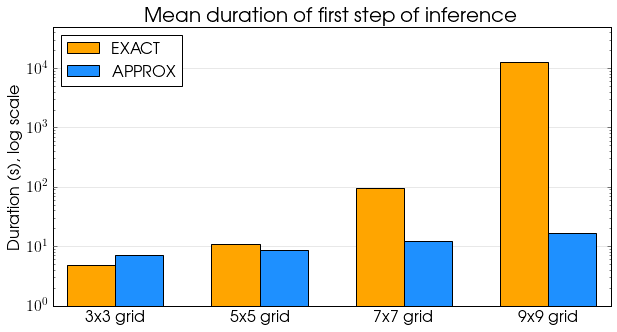

In [30]:
datas = get_duration_datas()
groups = ["3x3 grid",
          "5x5 grid",
          "7x7 grid",
          "9x9 grid"]
title = "Mean duration of first step of inference "
ylabel = "Duration (s), log scale"
ylim = (1e0, 5e4)
fig = plot_barchart(datas, groups, title, ylabel, ylim, yscale="log", figsize=(10,5), errbars=False)
fig.savefig('../results/one_step_duration.png', bbox_inches='tight')

<h1>Exact vs. approximate inference quality experiment</h1>

In [5]:
n_samples = 1000000

gt2 = [-0.33, -0.67]
l2e = L2Error(ground_truth=gt2)
oe = OrderError(ground_truth=gt2)
pe = ProportionError(ground_truth=gt2)
rnd_l2e_2f = [l2e._error([np.random.uniform(-1, 0) for i in range(2)]) for j in range(n_samples)]
rnd_oe_2f = [oe._error([np.random.uniform(-1, 0) for i in range(2)]) for j in range(n_samples)]
rnd_pe_2f = [pe._error([np.random.uniform(-1, 0) for i in range(2)]) for j in range(n_samples)]

gt3 = [-0.25, -0.5, -0.75]
l2e = L2Error(ground_truth=gt3)
oe = OrderError(ground_truth=gt3)
pe = ProportionError(ground_truth=gt3)
rnd_l2e_3f = [l2e._error([np.random.uniform(-1, 0) for i in range(3)]) for j in range(n_samples)]
rnd_oe_3f = [oe._error([np.random.uniform(-1, 0) for i in range(3)]) for j in range(n_samples)]
rnd_pe_3f = [pe._error([np.random.uniform(-1, 0) for i in range(3)]) for j in range(n_samples)]

random_L2_means = [np.mean(rnd_l2e_2f),
                   np.mean(rnd_l2e_3f)]
random_L2_stds = [np.std(rnd_l2e_2f),
                  np.std(rnd_l2e_3f)]
random_lp_means = [np.mean(rnd_pe_2f),
                   np.mean(rnd_pe_3f)]
random_lp_stds = [np.std(rnd_pe_2f),
                  np.std(rnd_pe_3f)]
random_ord_means = [np.mean(rnd_oe_2f),
                    np.mean(rnd_oe_3f)]
random_ord_stds = [np.std(rnd_oe_2f),
                   np.std(rnd_oe_3f)]

In [97]:
def get_comp_exp(grid, features, series, approx, exp, verbose):
    if len(exp) == 0:
        return None
    return ExperimentGroup("{}x{} grid {} features approx={}".format(grid, grid, features, approx), [
                ExperimentLog("../results/both6/g{}6_{}x{}_{}f_{}/experiment_approx_{}.json"
                              .format(series, grid, grid, features, i, approx), disc_err=True)
                for i in exp], verbose)

g7e = [get_comp_exp(7, 2, "b", False, range(1,31), True),
       get_comp_exp(7, 3, "b", False, range(1,31), True)]
g7a = [get_comp_exp(7, 2, "b", True, range(1,31), True),
       get_comp_exp(7, 3, "b", True, range(1,31), True)]
g9e = [get_comp_exp(9, 2, "b", False, range(1,31), True),
       get_comp_exp(9, 3, "b", False, range(1,31), True)]
g9a = [get_comp_exp(9, 2, "b", True, range(1,31), True),
       get_comp_exp(9, 3, "b", True, range(1,31), True)]
g13a = [get_comp_exp(13, 2, "a", True, range(1,31), True),
        get_comp_exp(13, 3, "a", True, range(1,31), True)]
g19a = [get_comp_exp(19, 2, "a", True, range(1,31), True),
        get_comp_exp(19, 3, "a", True, range(1,31), True)]

7x7 grid 2 features approx=False (30 experiments)
* Mean duration 3979.08 seconds
* L2 error to [-0.33 -0.67] mean 0.32
* Order error to [-0.33 -0.67] mean 0.40
* Proportion error to [-0.33 -0.67] mean -0.73
* disc_err mean 0.61
7x7 grid 3 features approx=False (30 experiments)
* Mean duration 9191.96 seconds
* L2 error to [-0.25 -0.5  -0.75] mean 0.45
* Order error to [-0.25 -0.5  -0.75] mean 1.40
* Proportion error to [-0.25 -0.5  -0.75] mean 0.13
* disc_err mean 0.86
7x7 grid 2 features approx=True (30 experiments)
* Mean duration 2380.09 seconds
* L2 error to [-0.33 -0.67] mean 0.27
* Order error to [-0.33 -0.67] mean 0.40
* Proportion error to [-0.33 -0.67] mean -0.63
* disc_err mean 0.45
7x7 grid 3 features approx=True (30 experiments)
* Mean duration 4035.22 seconds
* L2 error to [-0.25 -0.5  -0.75] mean 0.37
* Order error to [-0.25 -0.5  -0.75] mean 1.20
* Proportion error to [-0.25 -0.5  -0.75] mean -0.24
* disc_err mean 0.53
9x9 grid 2 features approx=False (30 experiments)
*

In [98]:
def get_new_comp_datas(typ=""):
    return ret_object(typ,
                     ("7x7 EXACT", "gold", "k", "/", g7e),
                     ("7x7 APPROX", "skyblue", "k", "/", g7a),
                     ("9x9 EXACT", "orange", "k", "//", g9e),
                     ("9x9 APPROX", "dodgerblue", "k", "//", g9a),
                     ("13x13 APPROX", "blue", "k", "", g13a),
                     ("19x19 APPROX", "slateblue", "k", "", g19a))

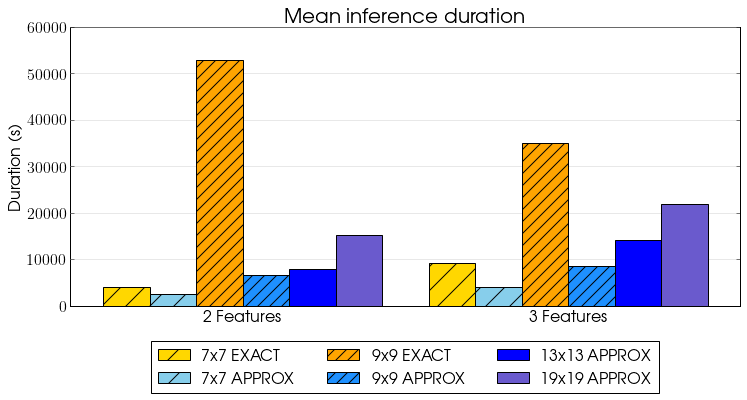

In [99]:
datas = get_new_comp_datas("duration")
groups = ["2 Features", "3 Features"]
title = "Mean inference duration"
ylabel = "Duration (s)"
ylim = (0, 60000)
fig = plot_barchart(datas, groups, title, ylabel, ylim, figsize=(12,5), leg_cols=3, leg_loc="out", errbars=False)
fig.savefig('../results/disc_duration_new.png', bbox_inches='tight')

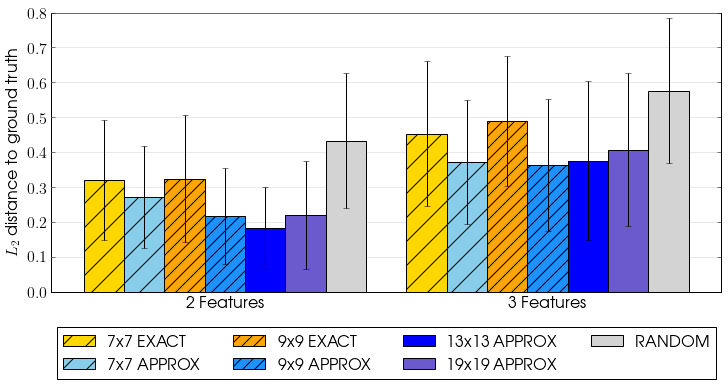

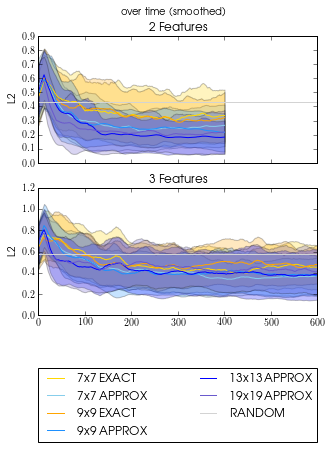

In [100]:
datas = get_new_comp_datas("L2")
datas.append(
    {"name": "RANDOM",
     "color": "lightgrey",
     "ecolor": "k",
     "hatch": "",
     "means": random_L2_means,
     "std": random_L2_stds})
groups = ["2 Features", "3 Features"]
title = "" #"Error in ML estimation"
ylabel = "$L_2$ distance to ground truth"
ylim = (0, 0.8)
fig = plot_barchart(datas, groups, title, ylabel, ylim, figsize=(12,5), leg_cols=4, leg_loc="out")
fig.savefig('../results/disc_l2_errors_comp_new.png', bbox_inches='tight')

fig = plot_graph(datas, groups, title+" over time", ylabel="L2", smooth=True)
fig.savefig('../results/disc_l2_errors_comp_temp_new.png', bbox_inches='tight')

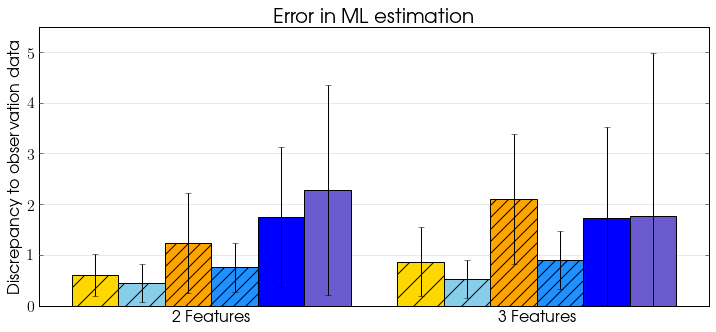

In [102]:
datas = get_new_comp_datas("disc_err")
groups = ["2 Features", "3 Features"]
title = "Error in ML estimation"
ylabel = "Discrepancy to observation data"
ylim = (0, 5.5)
fig = plot_barchart(datas, groups, title, ylabel, ylim, figsize=(12,5), leg_cols=3, leg_loc="none")
fig.savefig('../results/disc_disc_errors_comp_new.png', bbox_inches='tight')

<h1>Menu model posterior inference</h1>

In [18]:
md5_f13_i02 = ExperimentLog("../results/menu5/md5_f13_i02/experiment.json", posteriors=True).posteriors[-1]
md5_f23_i01 = ExperimentLog("../results/menu5/md5_f23_i01/experiment.json", posteriors=True).posteriors[-1]

(400, 2) (400, 1) ((0, 1), (0, 6))


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (-0.0006) as threshold


(400, 2) (400, 1) ((0, 1), (0, 6))


elfi.posteriors - INFO - Using minimum value of discrepancy estimate mean (-0.0005) as threshold


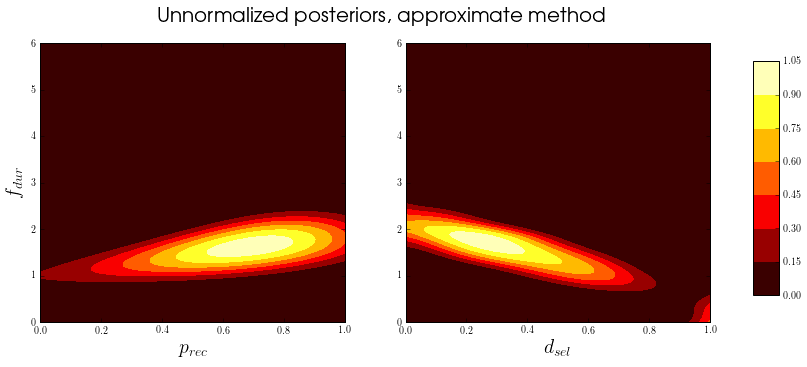

In [59]:
random.seed(0)
fig, axarr = pl.subplots(1, 2, figsize=(12,5))
pl.rc('text', usetex=True)
pl.rc('font', **{'family':'sans-serif','sans-serif':['Avant Garde']})
pl.suptitle(r"Unnormalized posteriors, approximate method", fontsize=20, x=0.52, y=1.0)
j = 0
for i in [0,1]:
    params = [(ClippedNormalPrior(0, 6, 3, 1), (0,6), r"$f_{dur}$"),
              (ClippedNormalPrior(0, 1, 0.3, 0.3), (0,1), r"$d_{sel}$"),
              (UniformPrior(0, 1), (0,1), r"$p_{rec}$")]
    data, x_id, y_id = [(md5_f13_i02, 0, 2),
                        (md5_f23_i01, 0, 1)][i]
    priors = [params[y_id][0], params[x_id][0]]
    bounds = (params[y_id][1], params[x_id][1])
    name_x = params[y_id][2]
    name_y = params[x_id][2]
    X = np.atleast_2d(data["X_params"])
    X[:,[0, 1]] = X[:,[1, 0]]
    Y = np.atleast_2d(data["Y_disc"])
    print(X.shape, Y.shape, bounds)

    gp = GPyModel(
                  input_dim=X.shape[1],
                  bounds=bounds,
                  kernel_class=GPy.kern.RBF,
                  kernel_var=data["kernel_var"],
                  kernel_scale=data["kernel_scale"],
                  noise_var=data["noise_var"],
                  max_opt_iters=100
                 )
    gp.update(X, Y)

    ax = axarr[j]
    ax.set_xlabel(name_x, fontsize=20)
    if j == 0:
        ax.set_ylabel(name_y, fontsize=20)
    post = BolfiPosterior(model=gp, threshold=None, priors=priors)
    vals = eval_2d_mesh(bounds[0][0], bounds[1][0], bounds[0][1], bounds[1][1], 150, 150, post.pdf)
    CS = ax.contourf(vals[0], vals[1], vals[2] / np.max(vals[2]), cmap='hot')
    j += 1
cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.65]) # left, bottom, width, height
fig.colorbar(CS, cax=cbar_ax)
pl.show()
fig.savefig('../results/menu_posteriors.png', bbox_inches='tight')